In [649]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.dates
from sklearn.ensemble import RandomForestClassifier


# Preprocess the data 
tl;dr: this part is just about examine the data quliaty, coherency, treat missing values, etc. Feel free to start with the next part-- process the data

In [441]:
#import driver data from csv
driver = pd.read_csv('driver_ids.csv')

driver['driver_onboard_date'] = pd.to_datetime(driver['driver_onboard_date'])
#check driver data basic summary 
driver.describe()


,driver_id,driver_onboard_date
count,937,937
unique,937,49
top,a85adc80be31a10c23b7aaf380e39173,2016-04-05 00:00:00
freq,1,36
first,NaN,2016-03-28 00:00:00
last,NaN,2016-05-15 00:00:00


In [442]:
#no missing values
driver.isnull().sum()

driver_id              0
driver_onboard_date    0
dtype: int64

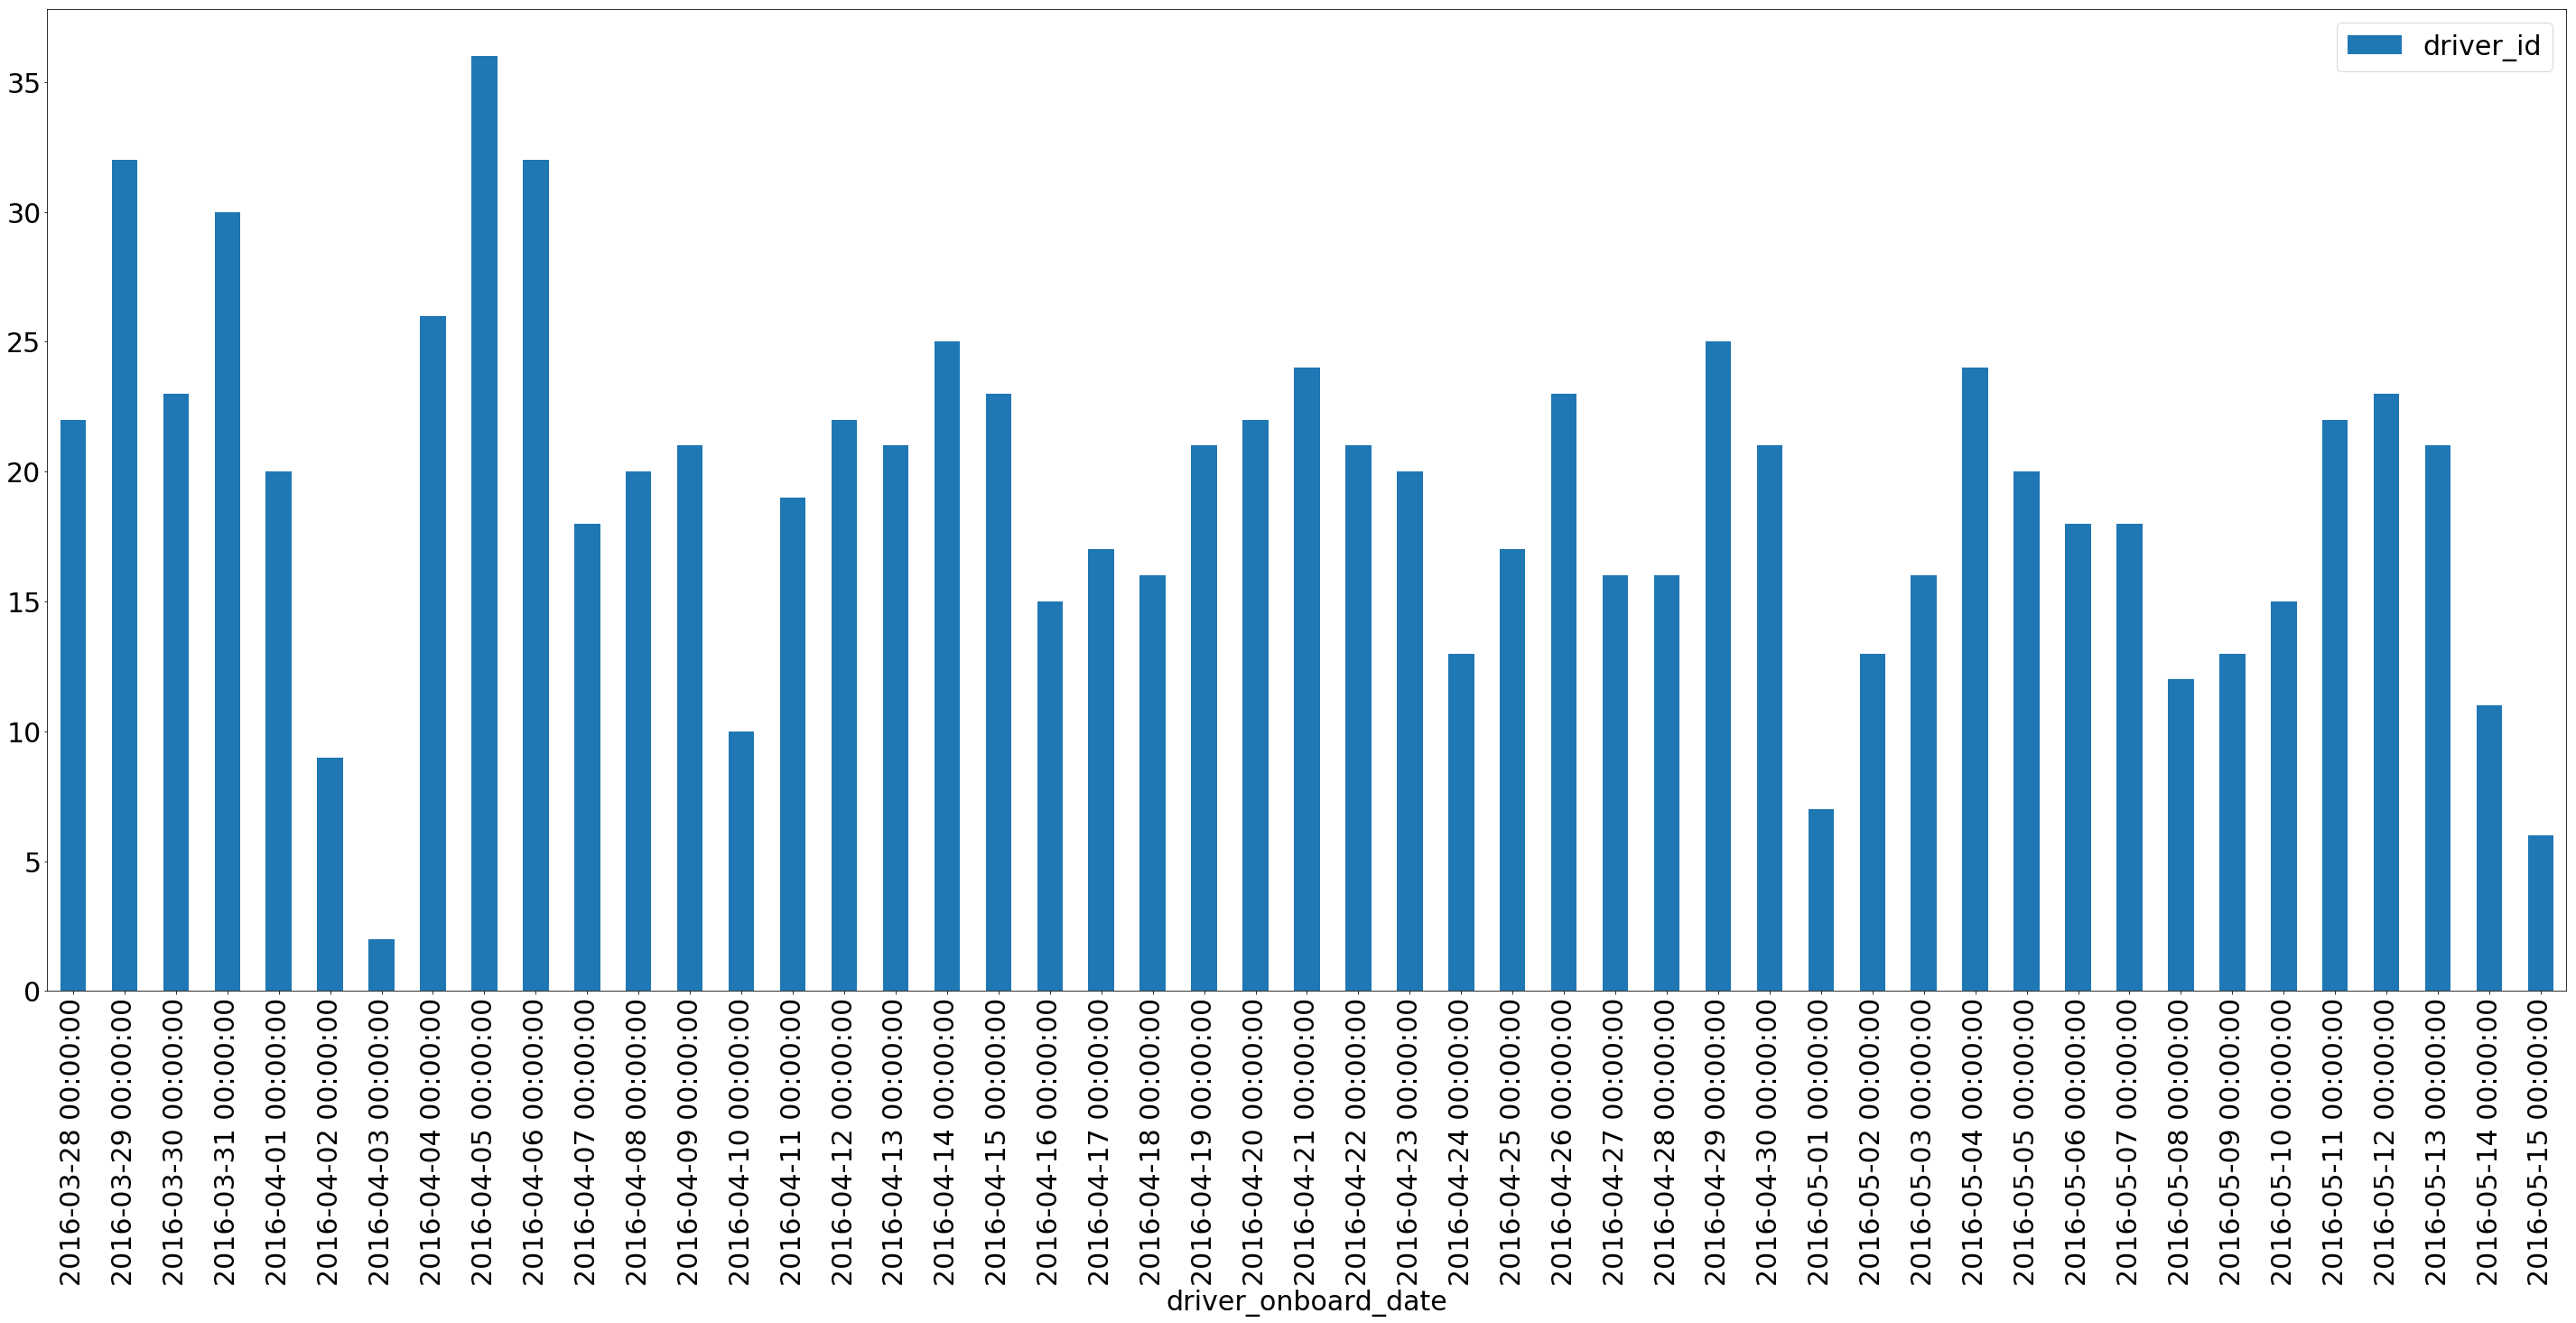

In [738]:
#look at driver onboard date distribution
plt.rcParams.update({'figure.figsize':[50,20], 'font.size':30})
driver.groupby(driver['driver_onboard_date']).count().plot(kind='bar')
plt.show()

The driver data sample contains drivers onboarded between 2016-03-28 to 2016-05-15, the distribution is fairly uniform with weekly cyclic pattern 

In [444]:
#import ride data and check summary
ride = pd.read_csv('ride_ids.csv')
ride.describe()

,ride_distance,ride_duration,ride_prime_time
count,193502.000000,193502.000000,193502.000000
mean,6955.218266,858.966099,17.305893
std,8929.444606,571.375818,30.825800
min,-2.000000,2.000000,0.000000
25%,2459.000000,491.000000,0.000000
50%,4015.000000,727.000000,0.000000
75%,7193.000000,1069.000000,25.000000
max,724679.000000,28204.000000,500.000000


There are records showing negative ride distance, it's probably due to data tracking error which need to be removed

In [445]:
#check missing value
ride.isnull().sum()

driver_id          0
ride_id            0
ride_distance      0
ride_duration      0
ride_prime_time    0
dtype: int64

In [446]:
#remove the records with negative ride distince 
ride = ride [ride['ride_distance']>0]
ride.describe()

,ride_distance,ride_duration,ride_prime_time
count,193315.000000,193315.000000,193315.000000
mean,6961.946290,859.633965,17.311254
std,8931.140532,571.122920,30.832015
min,1.000000,2.000000,0.000000
25%,2463.000000,492.000000,0.000000
50%,4020.000000,727.000000,0.000000
75%,7197.500000,1069.000000,25.000000
max,724679.000000,28204.000000,500.000000


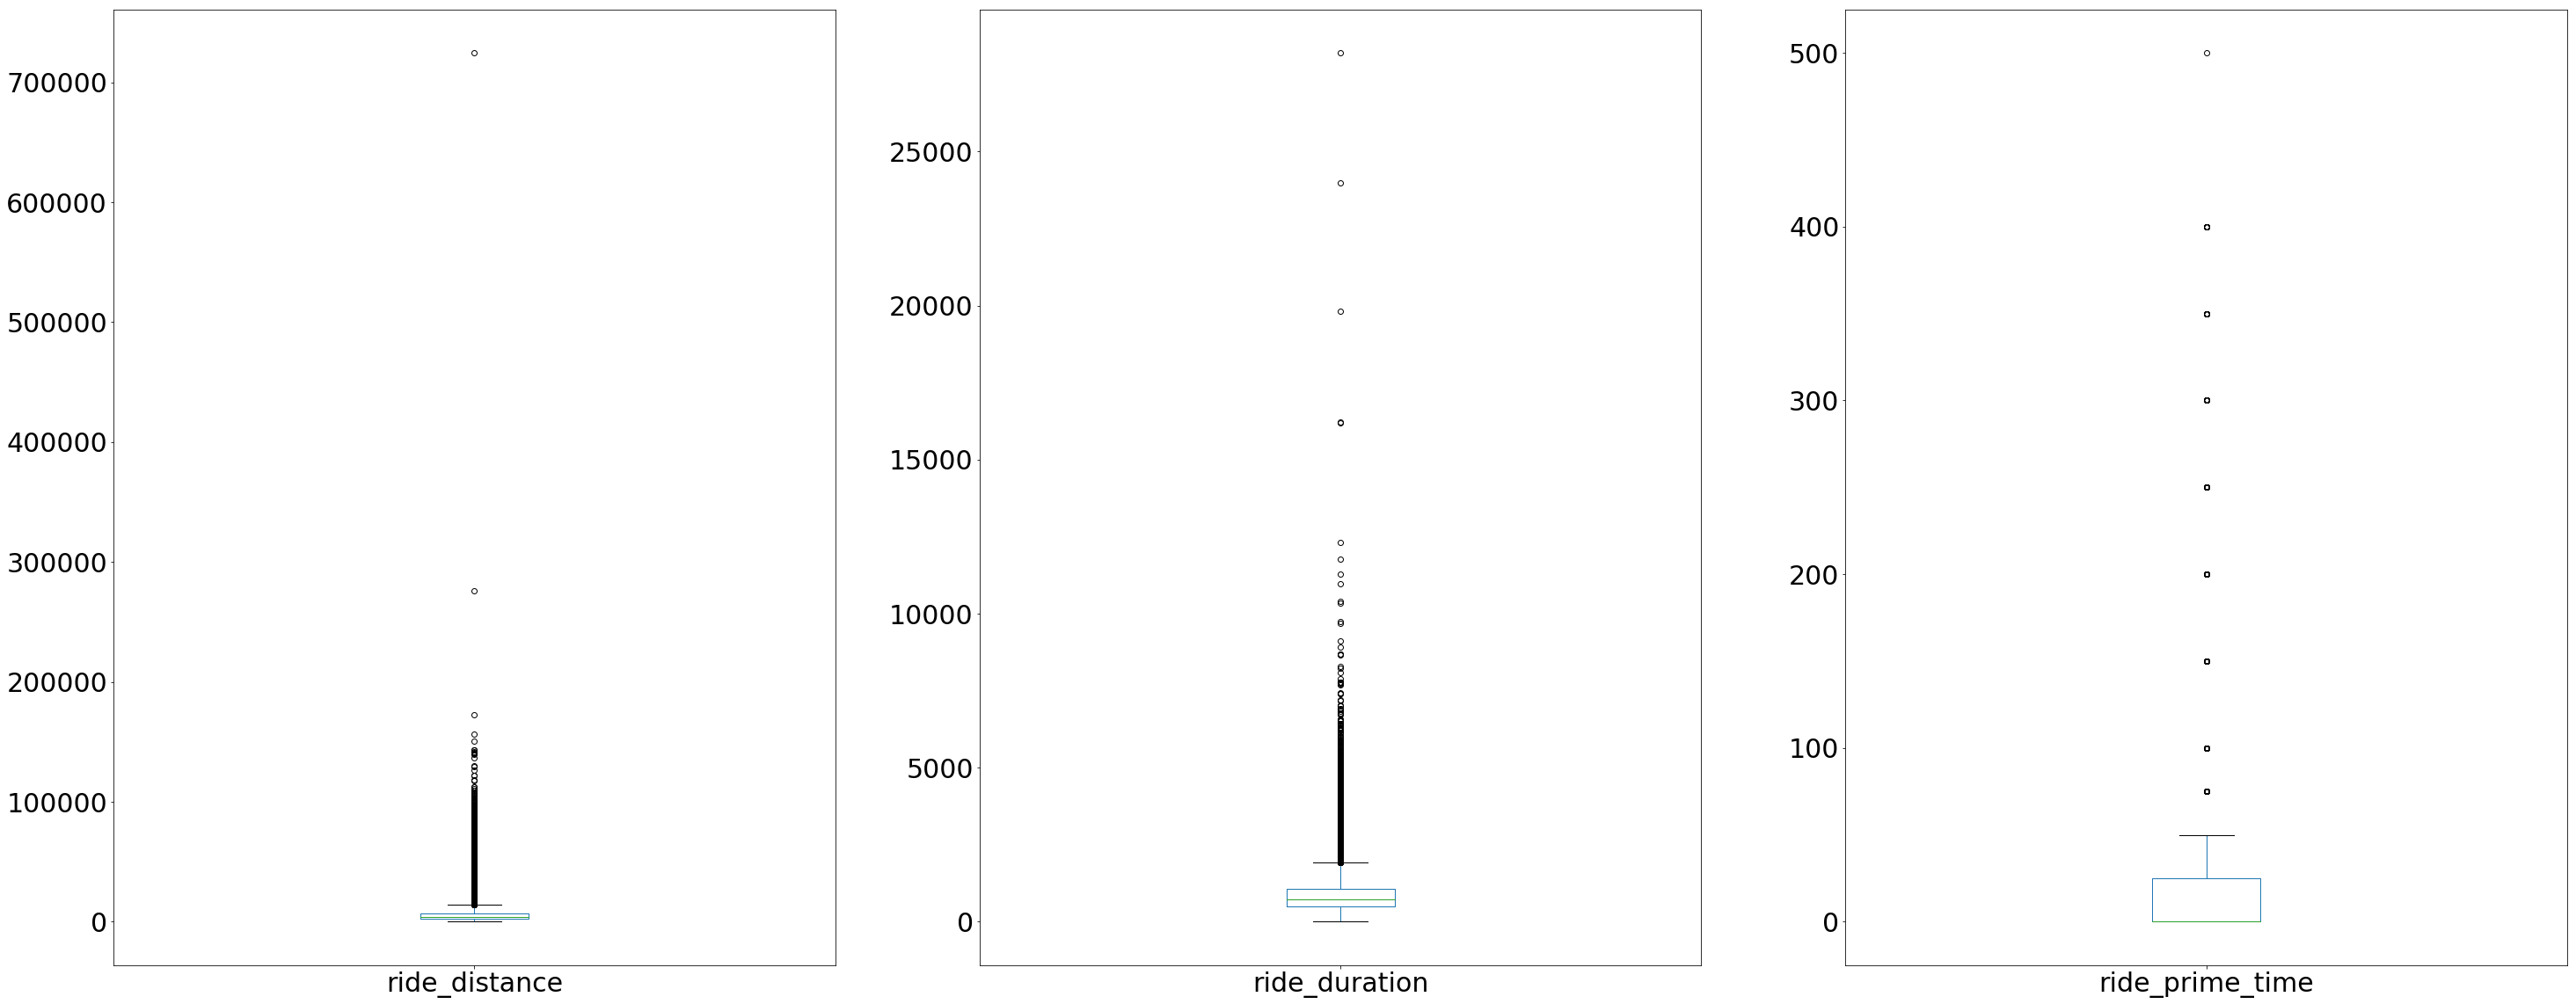

In [447]:
fig, (ax, ax1, ax2) = plt.subplots(ncols=3, sharey=False)

ride['ride_distance'].plot(kind="box", ax=ax)
ride['ride_duration'].plot(kind="box", ax=ax1)
ride['ride_prime_time'].plot(kind="box", ax=ax2)
plt.show()

In [448]:
#import ride ts data
ride_ts = pd.read_csv('ride_timestamps.csv')
ride_ts ['timestamp'] = pd.to_datetime(ride_ts ['timestamp'])
ride_ts.describe()

,ride_id,event,timestamp
count,970405,970405,970404
unique,194081,5,865826
top,51b44538f52ef231421b782e947b0b67,arrived_at,2016-04-30 22:09:15
freq,5,194081,7
first,NaN,NaN,2016-03-28 05:48:18
last,NaN,NaN,2016-06-27 00:50:50


In [449]:
#missing value? one timestamp is missing
ride_ts.isnull().sum()

ride_id      0
event        0
timestamp    1
dtype: int64

In [450]:
#what's the missing value
ride_ts[ride_ts.isnull().any(axis=1)]

,ride_id,event,timestamp
434222,72f0fa0bd86800e9da5c4dced32c8735,arrived_at,NaT


Since there is only one missing timestamp, we can do an imptation later to complete the data set

In [451]:
#data coherency check: to see if every ride has all 5 events
events_per_ride = ride_ts.groupby(['ride_id']).nunique()
events_per_ride.describe()

,ride_id,event,timestamp
count,194081.0,194081.0,194081.000000
mean,1.0,5.0,4.878391
std,0.0,0.0,0.329926
min,1.0,5.0,3.000000
25%,1.0,5.0,5.000000
50%,1.0,5.0,5.000000
75%,1.0,5.0,5.000000
max,1.0,5.0,5.000000


Event type is coherent, every ride has 5 unique events and no duplication in ride id

In [452]:
#pivot ride_ts table to make it convenient for future merging with ride data
ride_event = ride_ts.pivot(index='ride_id', columns='event', values='timestamp' )
ride_event.describe()

event,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at
count,194081,194080,194081,194081,194081
unique,190426,190526,190468,190524,190434
top,2016-06-02 16:00:22,2016-05-28 00:40:53,2016-06-03 18:59:26,2016-06-03 21:24:04,2016-05-06 20:39:08
freq,3,4,4,4,4
first,2016-03-28 05:48:23,2016-03-28 06:02:36,2016-03-28 06:37:51,2016-03-28 06:02:39,2016-03-28 05:48:18
last,2016-06-26 23:57:49,2016-06-27 00:02:03,2016-06-27 00:50:50,2016-06-27 00:02:06,2016-06-26 23:57:45


In [453]:
#fill the only missing value of arrive at timestamp based on the median of time difference from accept at to arrive at
ride_event['accpt_to_arrive'] = (ride_event['arrived_at']-ride_event['accepted_at']).astype('timedelta64[s]')
time_diff_mean = ride_event['accpt_to_arrive'].median()
ride_event.loc['72f0fa0bd86800e9da5c4dced32c8735','arrived_at']=ride_event.loc['72f0fa0bd86800e9da5c4dced32c8735','accepted_at'] + datetime.timedelta(0,time_diff_mean)
ride_event.loc['72f0fa0bd86800e9da5c4dced32c8735','accpt_to_arrive']=time_diff_mean

ride_event.loc['72f0fa0bd86800e9da5c4dced32c8735']

event
accepted_at        2016-04-20 11:57:20
arrived_at         2016-04-20 12:00:41
dropped_off_at     2016-04-20 12:16:30
picked_up_at       2016-04-20 12:02:20
requested_at       2016-04-20 11:56:50
accpt_to_arrive                    201
Name: 72f0fa0bd86800e9da5c4dced32c8735, dtype: object

In [454]:
#Data coherency check: is any ride that has earilier event's ts behind the later event, 
#i.e. accepted ts behind picked up ts
print(ride_event.query('accepted_at<requested_at').empty)
print(ride_event.query('arrived_at<accepted_at').empty)
print(ride_event.query('picked_up_at<arrived_at').empty)
print(ride_event.query('dropped_off_at<picked_up_at').empty)

True
True
False
True


Some rides have pick up event happened before arrive at event, let's see what they look like

In [455]:
pd.options.mode.chained_assignment = None  # default='warn'

In [456]:
#what are the typical time difference for these incoherent data?
ride_pu_b4_aa = ride_event[ride_event['picked_up_at']<ride_event['arrived_at']]
ride_pu_b4_aa['ts_diff'] = (ride_pu_b4_aa['picked_up_at'] - ride_pu_b4_aa['arrived_at']).astype('timedelta64[s]')
ride_pu_b4_aa['ts_diff'].value_counts()

-1.0       5905
-2.0       1616
-3.0        139
-5.0         12
-4.0         11
-11.0        10
-10.0        10
-6.0         10
-8.0         10
-237.0        6
-13.0         6
-189.0        6
-12.0         6
-14.0         6
-35.0         5
-38.0         5
-219.0        5
-7.0          5
-248.0        5
-15.0         5
-201.0        5
-92.0         5
-67.0         5
-78.0         5
-18.0         5
-208.0        4
-9.0          4
-306.0        4
-414.0        4
-90.0         4
           ... 
-1116.0       1
-996.0        1
-3476.0       1
-277.0        1
-397.0        1
-126.0        1
-478.0        1
-1008.0       1
-428.0        1
-809.0        1
-228.0        1
-783.0        1
-144.0        1
-672.0        1
-960.0        1
-352.0        1
-88.0         1
-72.0         1
-697.0        1
-281.0        1
-451.0        1
-683.0        1
-1169.0       1
-980.0        1
-892.0        1
-2676.0       1
-267.0        1
-519.0        1
-1061.0       1
-903.0        1
Name: ts_diff, Length: 4

Most of the difference between pick up and arrive at events are less than 10 seconds, it might be casued due to different system logs (i.e. arrived at ts and pick up ts are logged from separate driver and rider devices), in this case we are going to assume pick up happened at the same time of arrive at

In [457]:
#impute the timestamp of pick up to the same as arrive at timestamp for thoes rides have pick up happend 
#before arrive at

for index, row in ride_event.iterrows():
    if (ride_event.loc[index,'picked_up_at'] < ride_event.loc[index,'arrived_at']):
        ride_event.loc[index,'picked_up_at'] = ride_event.loc[index,'arrived_at']


In [520]:
#event time stamp data looks coherent now
print(ride_event.query('accepted_at<requested_at').empty)
print(ride_event.query('arrived_at<accepted_at').empty)
print(ride_event.query('picked_up_at<arrived_at').empty)
print(ride_event.query('dropped_off_at<picked_up_at').empty)

True
True
True
True


# Process the data, create a universal driver-ride table 

In [459]:
#merge ride data with ride event data
#I chose inner join here b/c we need the complete data of a ride, if the ride only has event info 
#but no duration/distince info, it cannot associate with the according drider id
# if the ride only has duration/distance info but no event info, we cannot tell when the ride happened
#thus it won't be possible to calculate driver's life time
ride_event.reset_index(inplace=True)
all_rides = pd.merge(ride,ride_event,how='inner', left_on='ride_id', right_on='ride_id')


In [521]:
#merge all rides data with driver data
#I chose left join here since we need to keep the drivers even though they don't have rides, it's very likely that
#then just signed up but never drove with Lyft
driver_ride = all_rides = pd.merge(driver,all_rides,how='left', left_on='driver_id', right_on='driver_id')


Index([u'driver_id', u'driver_onboard_date', u'driver_onboard_date_x',
       u'driver_onboard_date_y', u'ride_id', u'ride_distance',
       u'ride_duration', u'ride_prime_time', u'accepted_at', u'arrived_at',
       u'dropped_off_at', u'picked_up_at', u'requested_at',
       u'accpt_to_arrive'],
      dtype='object')

In [524]:
#add some ride features
#ride fare feature
#Assumptions: 
#The ride fare is composed from fixed fees+ variable charge
#variable charge is either charge by distance or charge by time, whichever is higher
#prime time has a flat surcharge rate of 100% of variable charges

for index, row in driver_ride.iterrows():
    charge_by_duration=driver_ride.loc[index,'ride_duration']/60*0.22+driver_ride.loc[index,'ride_prime_time']/60*0.22
    charge_by_distince=driver_ride.loc[index,'ride_distance']/1609.34*1.15+driver_ride.loc[index,'ride_prime_time']/1609.34*1.15
    if max([charge_by_duration,charge_by_distince])<5:
        driver_ride.loc[index,'ride_fare']=5
    if max([charge_by_duration,charge_by_distince])>400:
        driver_ride.loc[index,'ride_fare']=400
    else:
        driver_ride.loc[index,'ride_fare']=max([charge_by_duration,charge_by_distince])+2+1.75
   

In [566]:
#coutinue to add ride features
# is_prime_time_ride: boolean value represents if a ride has prime time or not
driver_ride['is_prime'] = driver_ride['ride_prime_time']>0

#convert ride date without time for calcuation of rides per day, weekend/weekday rides,etc.
driver_ride['ride_date'] = driver_ride['requested_at'].dt.floor('d')
driver_ride['ride_hour'] = driver_ride['requested_at'].dt.hour
driver_ride.sort_values(by=['driver_id','ride_date'], ascending=True, inplace=True)

#daytime vs after hour vs overnight rides
driver_ride['is_daytime_ride'] = (driver_ride['ride_hour']>=7) & (driver_ride['ride_hour']<=18)
driver_ride['is_afterhour_ride'] = (driver_ride['ride_hour']>=19) & (driver_ride['ride_hour']<=24)
driver_ride['is_overnight_ride'] = (driver_ride['ride_hour']>=0) & (driver_ride['ride_hour']<=6)

#weekend or weekday ride
driver_ride['is_weekday_ride'] = driver_ride['requested_at'].dt.dayofweek < 5

#identify rides on first day for later calculation of total rides on onboard day
driver_ride['ride_on_firstday'] = driver_ride['ride_date'] ==  driver_ride['driver_onboard_date']

#identify rides within first 7 days for later calculation of total rides in first 7 days
driver_ride['ride_in_first7days'] = driver_ride['ride_date'] <= (driver_ride['driver_onboard_date']+ datetime.timedelta(6,0))

#proxy column for rides cnt
driver_ride['ride_cnt'] = 1

# Determine how to define churn behavior

In [732]:
#There are two typical models to measure lifetime value
#1: Traditional model using weekly retention accounting to project average lifetime, the caluation is as below:
#  Churn rate = Drivers churned in this week/ Active drivers at beginning of this week
#  Average lifetime = 1/churn rate

#2:Predictive CLV model that projects the revenue a specific driver would gererate in a given future time frame 
# (usually it's next one year or month, not the whole lifetime since it's difficult to validate the model in real time)
# It usually involves 3 predicitve models, the first one is a conversion model, predicts if a given driver would churn
# or not in the future given time period, the second model is predicting the total rides a given driver would generate
# in given future time frame, the third one predicts the revenue per rides this driver would have
# In the end, the driver level lifetime value is the product of these three predicted results

#No matter which method we go with, we need to answer one question first: how to determin if a driver is churned or not?
#my mothedology:
#Take observation of the time intervals between driver's active days with Lyft (active day defined as they have at 
#least one ride on a given day), this represents the frequency of an active driver's replationship with Lyft. 
#From the below data, you will find >90% of the drivers never't stay inactive more than 24 consecutive days when
#they're driving with Lyft,so we can assume that any driver has been inactive more than 24 days should be considered 
#as churned

#Prepare the data
ride_interval = pd.DataFrame()
ride_interval['driver_id'] = driver_ride[['driver_id','ride_date']

#ride_interval.drop_duplicates(inplace=True)

#calculate the average of consecutive inactive days for each active driver
ride_interval['ride_date_lag'] = ride_interval.groupby(['driver_id'])['ride_date'].shift(1)
ride_interval['ride_time_interval'] = ride_interval['ride_date']-ride_interval['ride_date_lag']
ride_interval.fillna(datetime.timedelta(0,0),inplace=True)
ride_interval['ride_time_interval']= (ride_interval['ride_time_interval']/np.timedelta64(1, 'D')).astype(int)
ride_interval.replace(0,np.nan, inplace=True)


driver_interval_max = ride_interval.groupby(['driver_id']).max().reset_index().dropna()
driver_interval_max['interval_bin'] = driver_interval_max['ride_time_interval'].round()
#Plot the distribution of time inverval between active rides
driver_max_interval_dist=pd.DataFrame()
driver_max_interval_dist[['max_interval_in_days','driver_cnt']] = driver_interval_max.groupby(['interval_bin']).count().reset_index()[['interval_bin','driver_id']]
driver_max_interval_dist['cum_percent'] = driver_max_interval_dist['driver_cnt'].cumsum()/driver_time_interval_dist['driver_cnt'].sum()*100.0
driver_max_interval_dist



SyntaxError: invalid syntax (<ipython-input-732-c5a0da4d10ad>, line 25)

    max_interval_in_days  driver_cnt  cum_percent
0                    1.0          14     1.658768
1                    2.0          46     7.109005
2                    3.0          70    15.402844
3                    4.0          66    23.222749
4                    5.0          81    32.819905
5                    6.0          69    40.995261
6                    7.0          72    49.526066
7                    8.0          48    55.213270
8                    9.0          45    60.545024
9                   10.0          30    64.099526
10                  11.0          27    67.298578
11                  12.0          32    71.090047
12                  13.0          18    73.222749
13                  14.0          19    75.473934
14                  15.0          25    78.436019
15                  16.0          19    80.687204
16                  17.0          12    82.109005
17                  18.0          16    84.004739
18                  19.0           8    84.952607


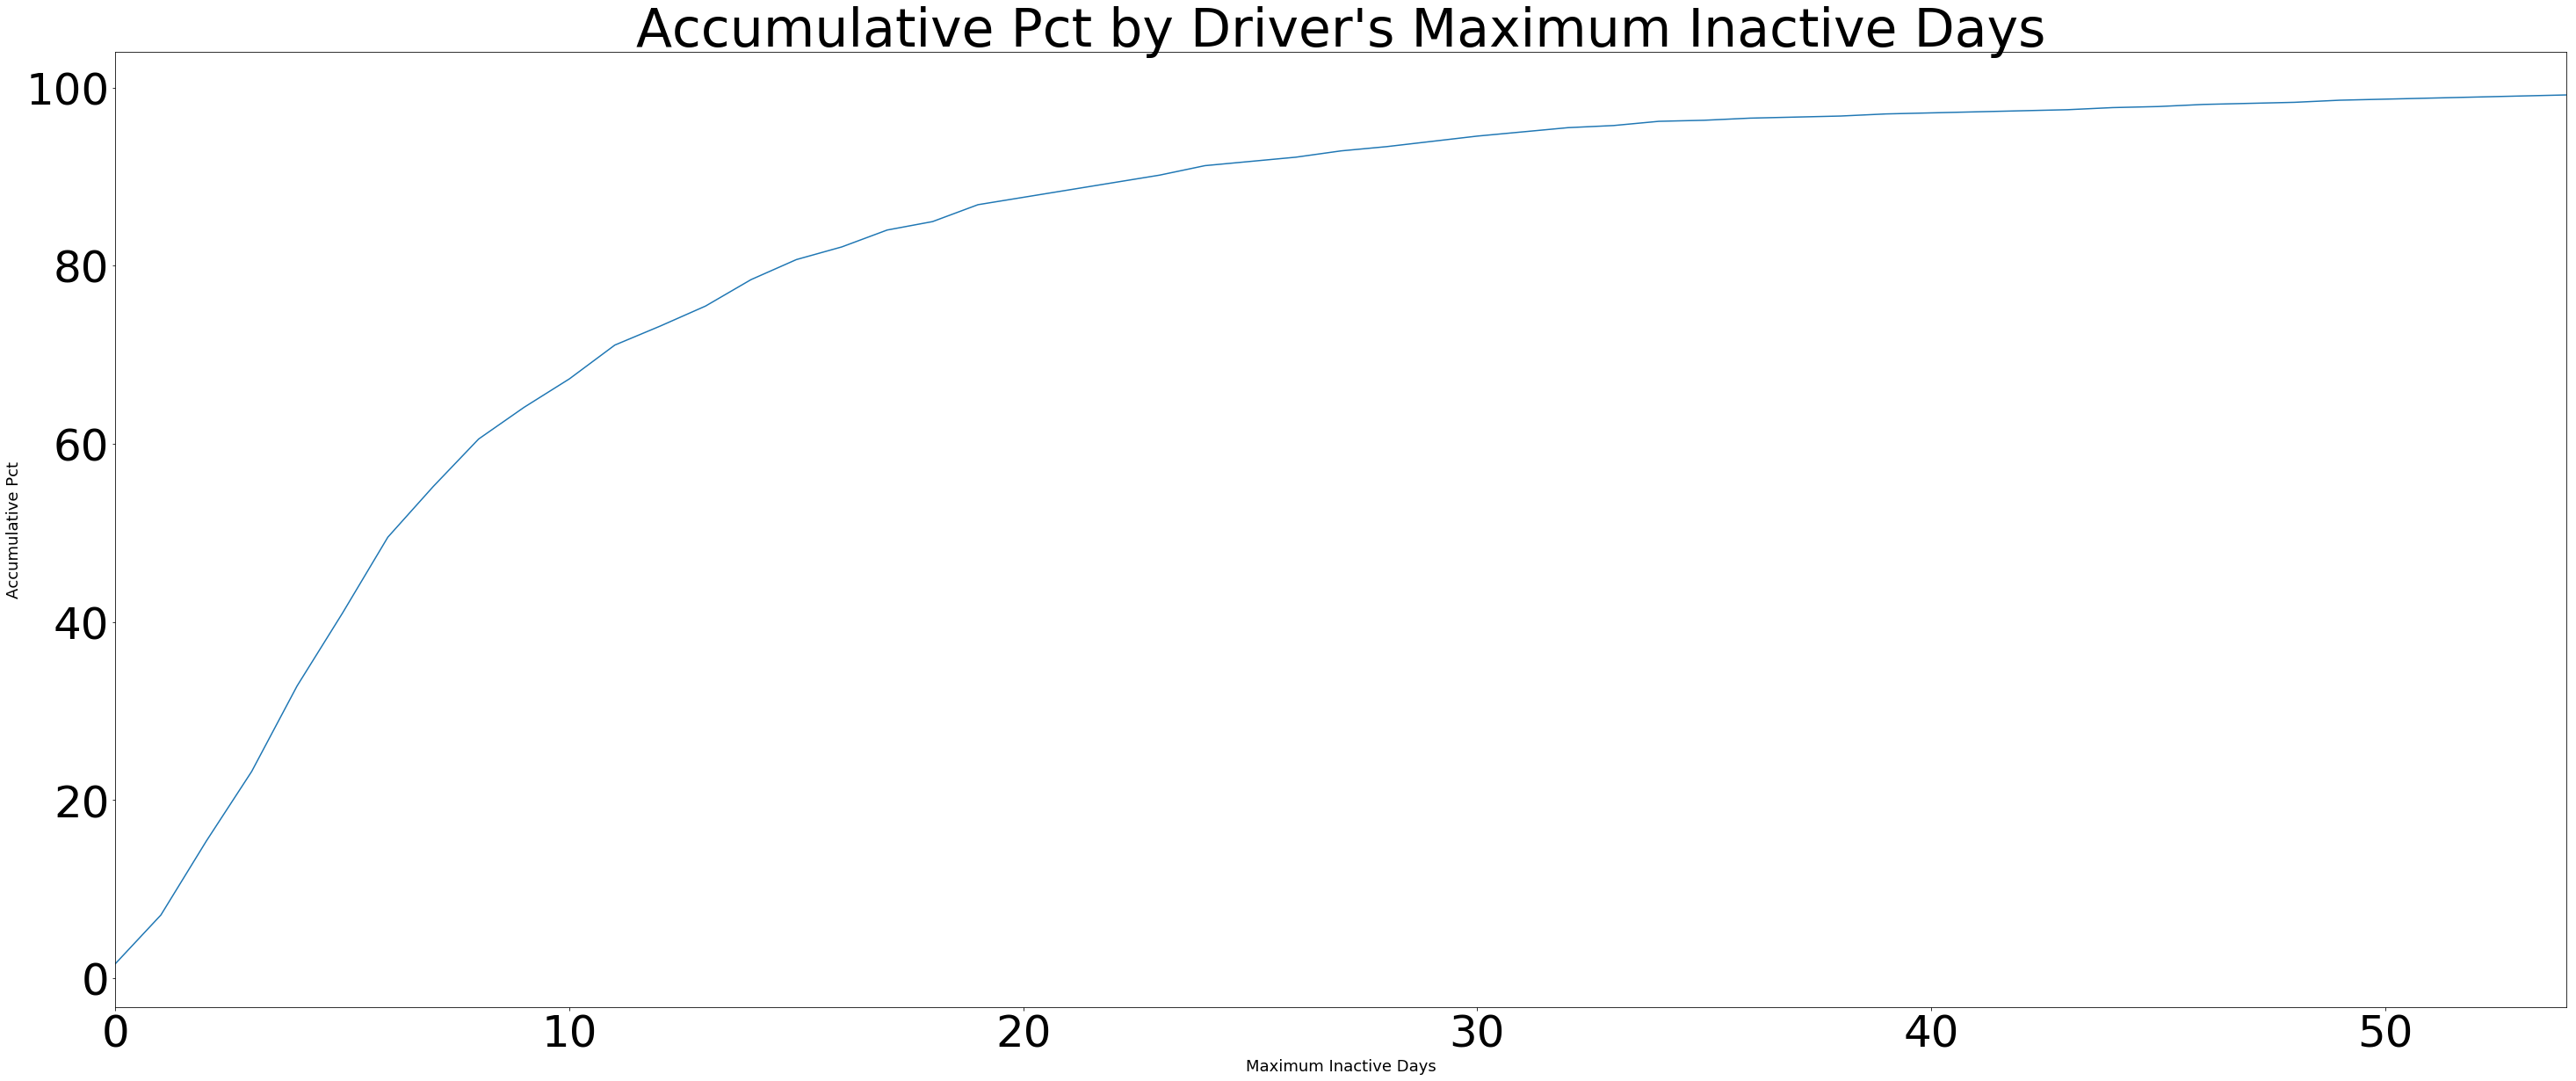

In [757]:
print(driver_max_interval_dist)

plt.rcParams.update({'figure.figsize':[50,20], 'font.size':50,'axes.titlesize': 'large'})
driver_max_interval_dist['cum_percent'].plot(kind='line')
plt.xlabel("Maximum Inactive Days",fontsize=18)
plt.ylabel("Accumulative Pct",fontsize=18)                                        
plt.title("Accumulative Pct by Driver's Maximum Inactive Days")
                                         
plt.show()

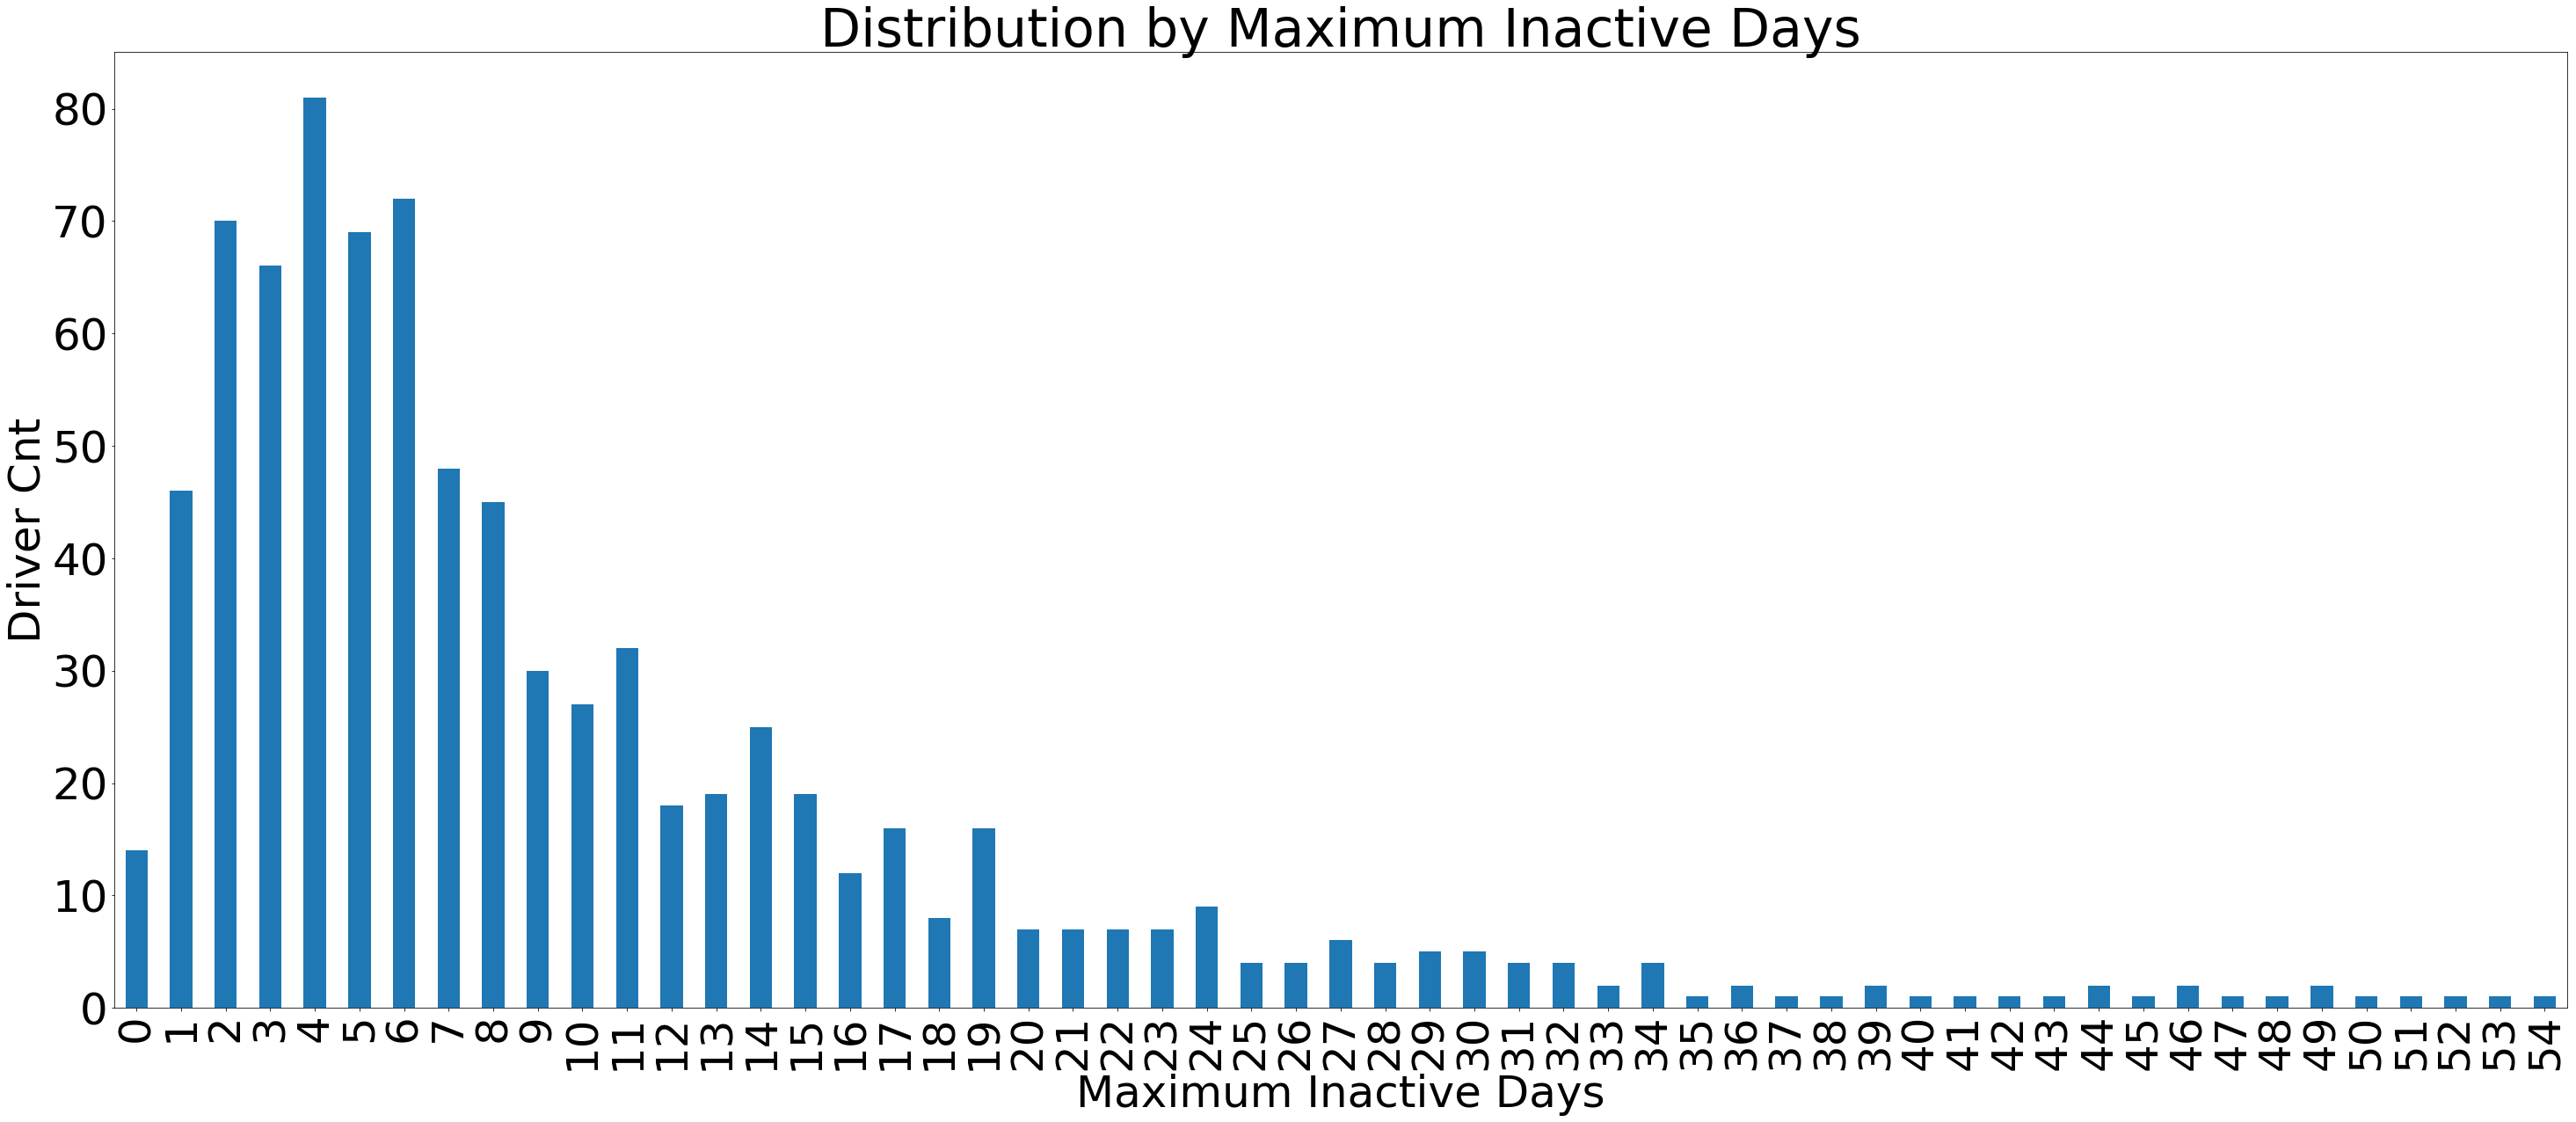

In [751]:
driver_max_interval_dist['driver_cnt'].plot(kind='bar')
plt.xlabel("Maximum Inactive Days")
plt.ylabel("Driver Cnt")                                        
plt.title("Distribution by Maximum Inactive Days")
                                         
plt.show()

# Using traditional model to project driver's lifetime

In [523]:
#Data sample used 
# week1: 4/21/2016 - 4/27/2016
# week2: 4/28/2016 - 5/4/2016
# week3: 5/5/2016 -5/11/2016
#The first registration starts on 3/28, per our definition, 4/21 is the first day we may start to have churned drivers,
#thus I chose this time frame to calculate
# apply the weekly retention accounting for these 3 weeks
#  Churn rate = Drivers churned in this week/ Active drivers at beginning of this week
#  Average lifetime = 1/churn rate
# Since the data is only sampled from a short time period, the weeks I picked are the first 3 weeks we start having 
# churns, the churn rate each week can be very different, the overall projection will take the mean out of these 3 
# weekly projections

wk1_begin = datetime.datetime.strptime("04-21-2016", "%m-%d-%Y")
wk2_begin = datetime.datetime.strptime("04-28-2016", "%m-%d-%Y")
wk3_begin = datetime.datetime.strptime("05-05-2016", "%m-%d-%Y")
wk3_end = datetime.datetime.strptime("05-11-2016", "%m-%d-%Y")
#registrations in each time period
regs_before_wk1 = driver_ride[driver_ride['driver_onboard_date']<wk1_begin]['driver_id'].nunique()
regs_in_wk1 = driver_ride[(driver_ride['driver_onboard_date']>=wk1_begin)&(driver_ride['driver_onboard_date']<wk2_begin) ]['driver_id'].nunique()
regs_in_wk2 = driver_ride[(driver_ride['driver_onboard_date']>=wk2_begin)&(driver_ride['driver_onboard_date']<wk3_begin) ]['driver_id'].nunique()

# calucate the churns of each week
wk1_rides = driver_ride[driver_ride['requested_at']<wk2_begin]
wk1_driver_last_ride = wk1_rides.groupby(['driver_id']).last().reset_index()[['driver_id','requested_at']]
churns_in_wk1 = wk1_driver_last_ride[((wk2_begin-wk1_driver_last_ride['requested_at'])/np.timedelta64(1, 'D')).astype(int)>25]['driver_id'].nunique()

wk2_rides = driver_ride[driver_ride['requested_at']<wk3_begin]
wk2_driver_last_ride = wk2_rides.groupby(['driver_id']).last().reset_index()[['driver_id','requested_at']]
churns_in_wk2 = wk2_driver_last_ride[((wk3_begin-wk2_driver_last_ride['requested_at'])/np.timedelta64(1, 'D')).astype(int)>25]['driver_id'].nunique()

wk3_rides = driver_ride[driver_ride['requested_at']<=wk3_end]
wk3_driver_last_ride = wk3_rides.groupby(['driver_id']).last().reset_index()[['driver_id','requested_at']]
churns_in_wk3 = wk3_driver_last_ride[((wk3_end-wk3_driver_last_ride['requested_at'])/np.timedelta64(1, 'D')).astype(int)>24]['driver_id'].nunique()

#apply the retention accouting to all three weeks
wk1_churn_rate = float(churns_in_wk1)/float(regs_before_wk1)
wk2_churn_rate = float(churns_in_wk2)/float(regs_before_wk1-churns_in_wk1+regs_in_wk1)
wk3_churn_rate = float(churns_in_wk3)/float(regs_before_wk1-churns_in_wk1+regs_in_wk1-churns_in_wk2+regs_in_wk2)

print('Weekly churn rates are')
print([wk1_churn_rate, wk2_churn_rate, wk3_churn_rate])

#weely lifetime projection = 1/weekly churn rate, the overall projection takes the mean of the three
avg_lifetime= sum([1/wk1_churn_rate, 1/wk2_churn_rate, 1/wk3_churn_rate])/3
print('Projected average life time is')
print(avg_lifetime) 
print('weeks')


Weekly churn rates are
[0.05776892430278884, 0.14991762767710048, 0.24921630094043887]
Projected average life time is
9.33108437142
weeks


# Discover drivers' predictive indicator of driver's churn

In [700]:
#We can use some feature selection techniques to find out which bahavioral indications have influence on if a given
#driver churns or not
#First we need to build a driver feature table
driver_features = driver_ride[['driver_id','driver_onboard_date']]
driver_features.drop_duplicates(inplace=True)
min_features = driver_ride.groupby(['driver_id']).min().reset_index()[['driver_id','requested_at']]
driver_features = pd.merge(driver_features,min_features)
driver_features.columns = ['driver_id','driver_onboard_date','first_ride_date']

max_features = driver_ride.groupby(['driver_id']).max().reset_index()[['driver_id','requested_at']]
driver_features = pd.merge(driver_features,max_features)


sum_features = driver_ride.groupby(['driver_id']).sum().reset_index()[['driver_id','ride_fare','ride_distance',
                                                                       'ride_duration','ride_prime_time','is_prime',
                                                                      'is_daytime_ride','is_afterhour_ride','is_overnight_ride',
                                                                      'is_weekday_ride','ride_on_firstday','ride_in_first7days',
                                                                      'ride_cnt']]
driver_features = pd.merge(driver_features,sum_features)


cntd_features = driver_ride.groupby(['driver_id']).nunique().rename(columns={'driver_id':'id_cntd'}).reset_index()[[
    'driver_id','ride_date']]
driver_features = pd.merge(driver_features,cntd_features)

driver_features.columns = ['driver_id','driver_onboard_date','first_ride_date','last_ride_date','total_ride_fare',
                           'total_ride_distance','total_ride_duration','total_ride_prime_time','total_prime_rides',
                          'total_daytime_rides','total_afterhour_rides','total_overnight_rides','total_weekday_rides',
                          'total_rides_on_firstday','total_rides_in_first7days','total_rides','days_riding']

#more derieved features
driver_features['rides_per_day'] = driver_features['total_rides']/driver_features['days_riding']
driver_features['fare_per_ride'] = driver_features['total_ride_fare']/driver_features['total_rides']
driver_features['duration_per_ride'] = driver_features['total_ride_duration']/driver_features['total_rides']
driver_features['distince_per_ride'] = driver_features['total_ride_distance']/driver_features['total_rides']
driver_features['avg_speed'] = driver_features['total_ride_distance']/driver_features['total_ride_duration']
driver_features['prime_time_per_ride'] = driver_features['total_ride_prime_time']/driver_features['total_rides']
driver_features['prime_time_ratio'] = driver_features['total_prime_rides']/driver_features['total_rides']
driver_features['weekday_ratio'] = driver_features['total_weekday_rides']/driver_features['total_rides']
driver_features['daytime_ratio'] = driver_features['total_daytime_rides']/driver_features['total_rides']
driver_features['afterhour_ratio'] = driver_features['total_afterhour_rides']/driver_features['total_rides']
driver_features['overnight_ratio'] = driver_features['total_overnight_rides']/driver_features['total_rides']
#drop the drivers have no features, i.e. the drivers signed up but never drived
driver_features.dropna(inplace=True)
driver_features['days_till_first_ride'] = ((driver_features['first_ride_date']-driver_features['driver_onboard_date'])
                                      /np.timedelta64(1,'D')).astype(int)
driver_features['active_day_freq'] = (((driver_features['last_ride_date']-driver_features['first_ride_date'])
                                      /np.timedelta64(1,'D')).astype(int))/driver_features['days_riding']

#create the final feature table
driver_ft_final = driver_features[['driver_id','total_rides_on_firstday','total_rides_in_first7days','rides_per_day',
                                  'fare_per_ride','duration_per_ride','distince_per_ride','avg_speed','prime_time_per_ride',
                                  'prime_time_ratio','weekday_ratio','daytime_ratio','afterhour_ratio','overnight_ratio',
                                  'days_till_first_ride','active_day_freq']]



In [701]:
#add the churn flag
driver_interval_max['churn_flag'] = (driver_interval_max['ride_time_interval']>24)*1
driver_churn = driver_interval_max[['driver_id','churn_flag']]
driver_ft_final = pd.merge(driver_ft_final,driver_churn)
driver_ft_final.set_index('driver_id',inplace=True)
driver_ft_final.head()

,total_rides_on_firstday,total_rides_in_first7days,rides_per_day,fare_per_ride,duration_per_ride,distince_per_ride,avg_speed,prime_time_per_ride,prime_time_ratio,weekday_ratio,daytime_ratio,afterhour_ratio,overnight_ratio,days_till_first_ride,active_day_freq,churn_flag
driver_id,,,,,,,,,,,,,,,,
002be0ffdc997bd5c50703158b7c2491,6.0,26.0,4.946429,8.481477,798.693141,6282.624549,7.866131,19.404332,0.397112,0.772563,0.422383,0.418773,0.158845,0,1.517857,0
007f0389f9c7b03ef97098422f902e62,1.0,1.0,2.583333,6.702265,661.193548,3791.322581,5.734059,20.161290,0.387097,0.709677,0.419355,0.580645,0.000000,0,7.000000,0
011e5c5dfc5c2c92501b8b24d47509bc,2.0,7.0,2.833333,9.635441,858.970588,7930.970588,9.233111,19.852941,0.470588,0.529412,0.470588,0.470588,0.058824,0,5.666667,0
0152a2f305e71d26cc964f8d4411add9,0.0,23.0,4.775000,9.380735,913.722513,7702.821990,8.430155,10.732984,0.251309,0.801047,0.403141,0.261780,0.335079,2,1.525000,0
01674381af7edd264113d4e6ed55ecda,5.0,45.0,9.375000,9.954647,953.181333,8329.717333,8.738859,12.533333,0.264000,1.000000,0.933333,0.000000,0.066667,0,1.400000,0


Features sorted by their score:
[(0.1059, 'weekday_ratio'), (0.1009, 'avg_speed'), (0.0912, 'rides_per_day'), (0.0835, 'prime_time_ratio'), (0.0818, 'prime_time_per_ride'), (0.0795, 'duration_per_ride'), (0.0787, 'distince_per_ride'), (0.0726, 'fare_per_ride'), (0.0711, 'total_rides_in_first7days'), (0.0699, 'afterhour_ratio'), (0.0669, 'daytime_ratio'), (0.0524, 'overnight_ratio'), (0.0422, 'total_rides_on_firstday'), (0.0032, 'days_till_first_ride')]


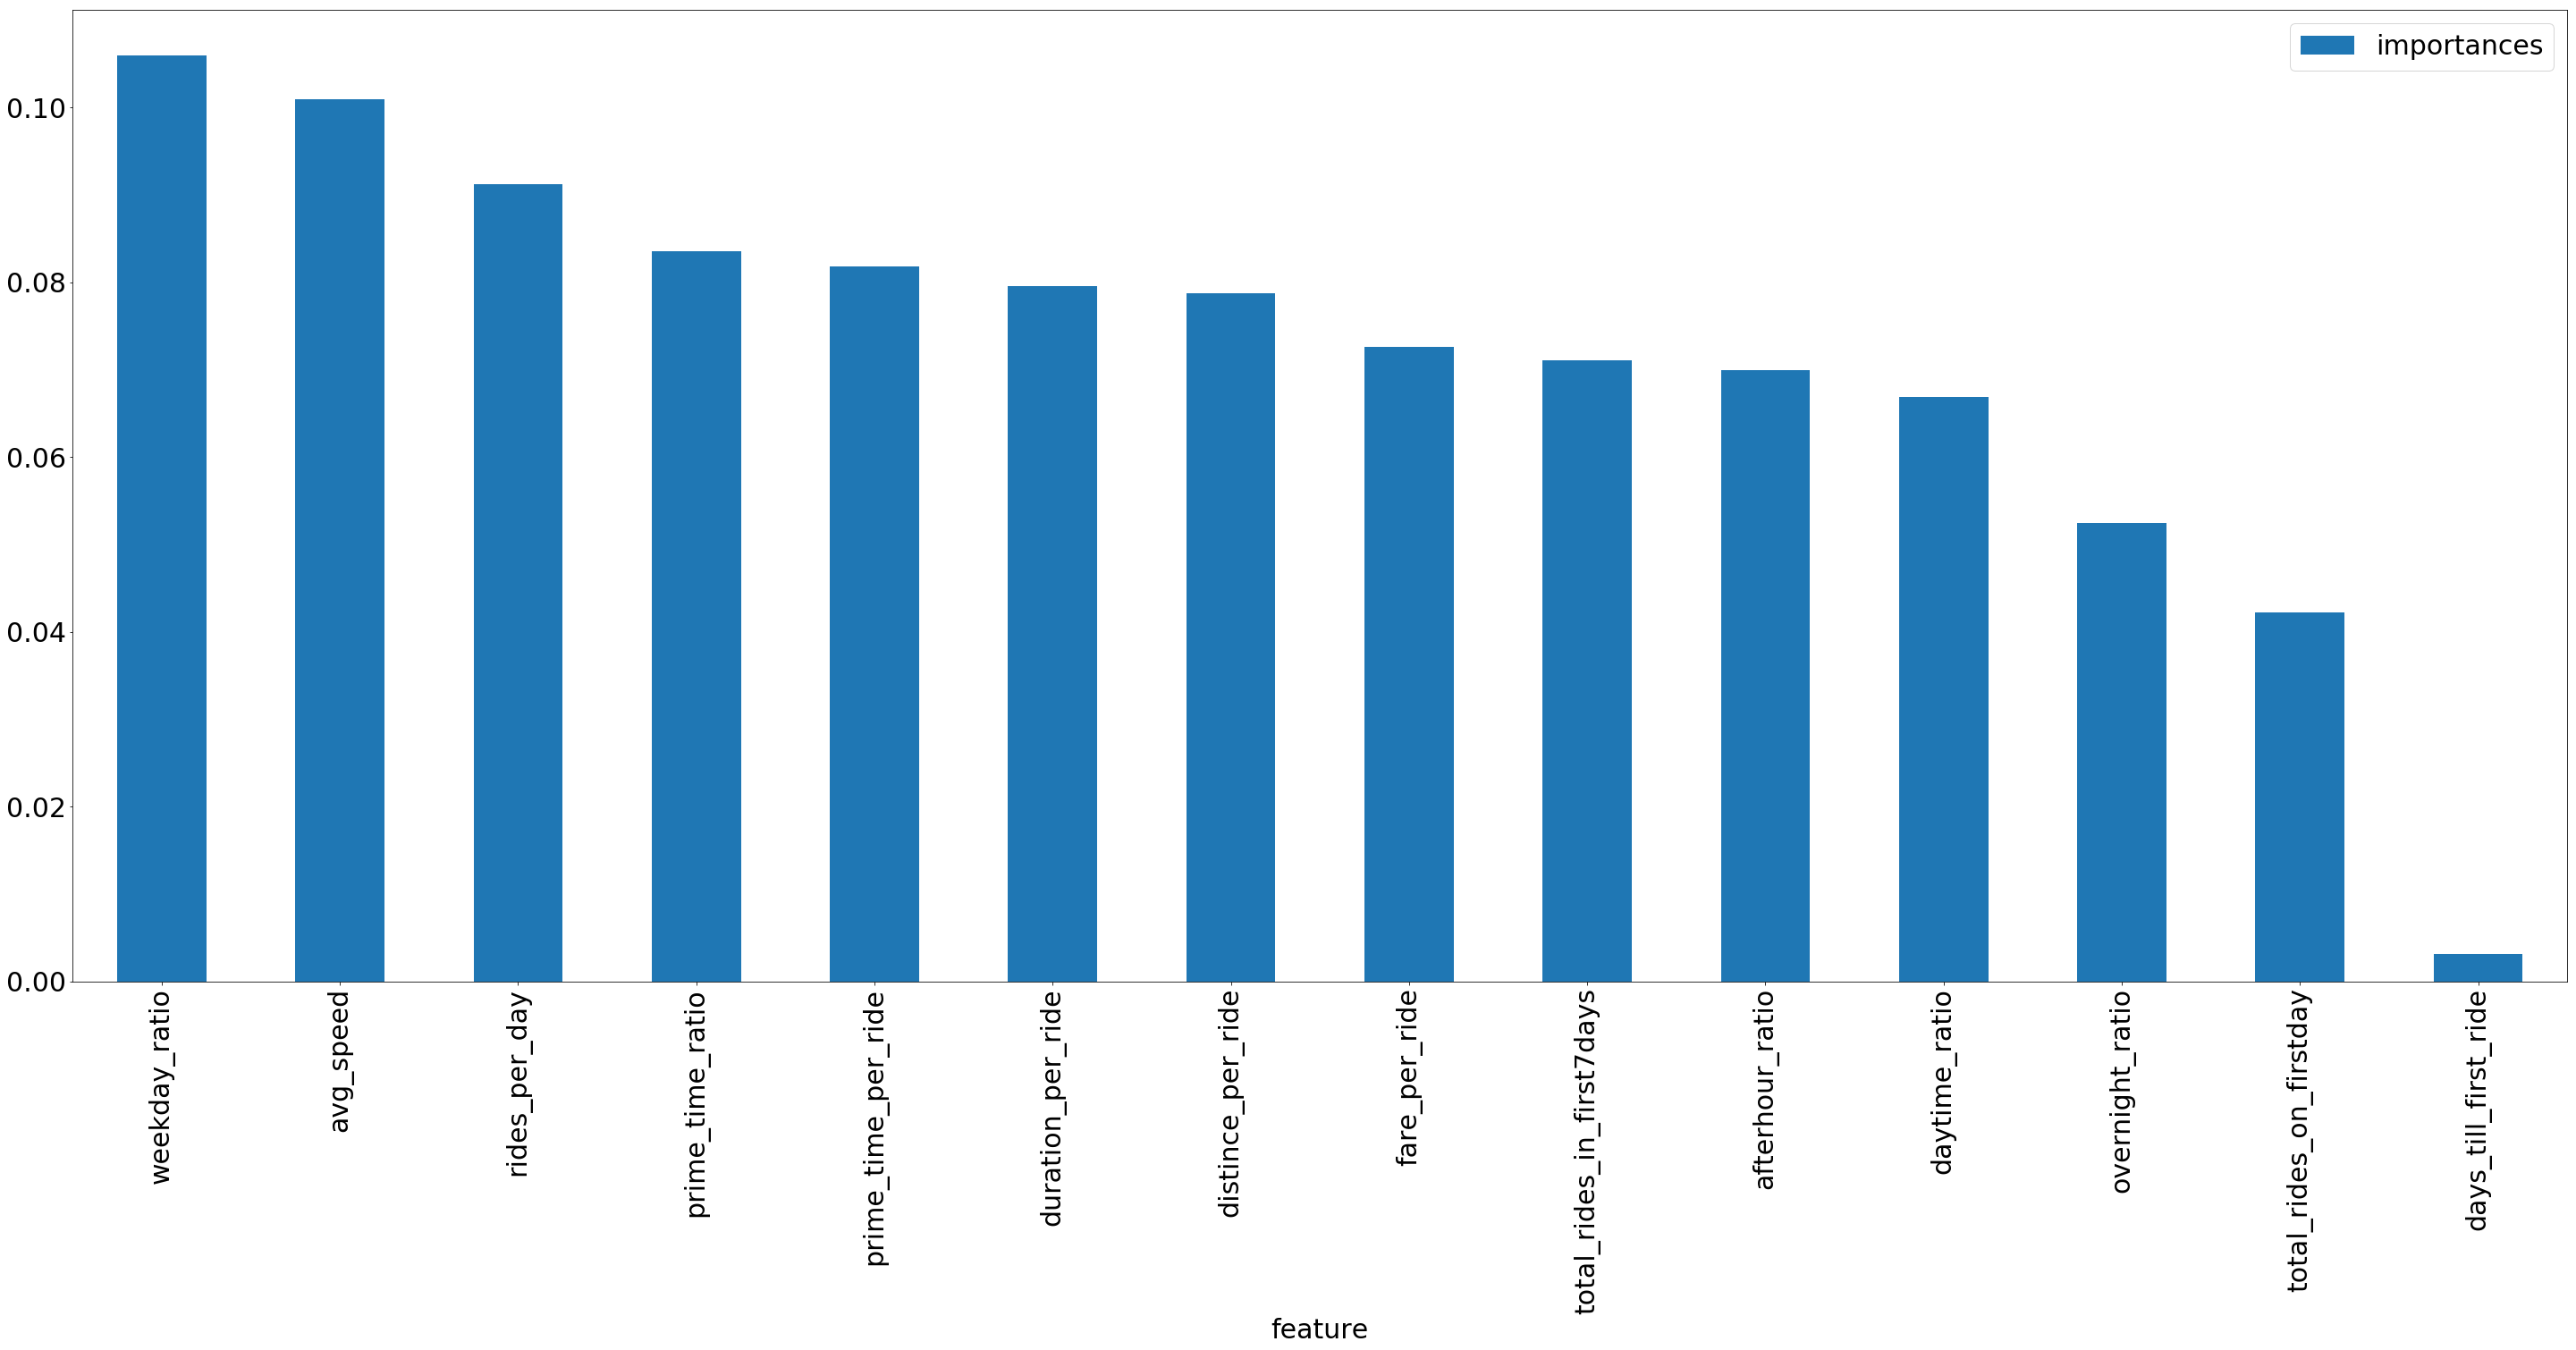

In [679]:
#Use a random forest classifier to review the feature importance toward user churn
X = driver_ft_final.iloc[:,0:14]
Y = driver_ft_final.iloc[:,-1]
names = driver_ft_final.columns.values

rfc = RandomForestClassifier(n_estimators=300)

# Fit the model
rfc.fit(X, Y)

# Print the results
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), names), reverse=True))

ft_imp = pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), names), reverse=True))
ft_imp.columns=['importances','feature']
ft_imp.set_index('feature',inplace=True)
ft_imp.plot(kind='bar')
plt.show()

The most outstand feature (driver bahavior) here is ratio of rides completed on weekdays, average speed on rides and average rides completed on the active days

# Leverage outstand features to explore driver churn behavior

In [720]:
#Using a tree model based on the most outstand features to explore if drivers have different churn behavior
#let's use the quantile segments on the three most out stand features: weekday ratio, average speed and rides per day 


driver_ft_final['weekday_ratio_pct_rnk'] = driver_ft_final['weekday_ratio'].rank(pct=True)
driver_ft_final['avg_speed_pct_rnk'] = driver_ft_final['avg_speed'].rank(pct=True)
driver_ft_final['rides_per_day_pct_rnk'] = driver_ft_final['rides_per_day'].rank(pct=True)

def seg(pct_rank):
    if pct_rank<=float(0.25):
        return '0-25'
    elif (pct_rank>float(0.25) and pct_rank<=float(0.5)):
        return '25-50'
    elif (pct_rank>float(0.5) and pct_rank<=float(0.75)):
        return '50-75'
    else:
        return '75-100'
    

driver_ft_final['weekday_ratio_seg'] = driver_ft_final['weekday_ratio_pct_rnk'].apply(seg)
driver_ft_final['avg_speed_seg'] = driver_ft_final['avg_speed_pct_rnk'].apply(seg)
driver_ft_final['rides_per_day_seg'] = driver_ft_final['rides_per_day_pct_rnk'].apply(seg)





In [729]:
driver_ft_final.describe()[['weekday_ratio','avg_speed','rides_per_day']]

,weekday_ratio,avg_speed,rides_per_day
count,837.000000,837.000000,837.000000
mean,0.710420,8.343855,6.388361
std,0.181770,1.852148,2.788625
min,0.000000,4.811031,1.000000
25%,0.614035,6.983816,4.300000
50%,0.725000,8.053216,6.200000
75%,0.827586,9.236239,8.151515
max,1.000000,16.604347,17.500000


In [723]:
#4 segements
#low weekday ratio --> very high churn%
#high weekday ration --> very high churn%
#mid band weekday ratio works best


churn_by_weekday_ratio = driver_ft_final.groupby(['weekday_ratio_seg']).agg({'churn_flag':'sum','weekday_ratio_seg':'count'}).rename(
    columns={'churn_flag':'churns','weekday_ratio_seg':'total_drivers'})
churn_by_weekday_ratio['churn%'] = churn_by_weekday_ratio['churns']/churn_by_weekday_ratio['total_drivers']*100.0
churn_by_weekday_ratio

,churns,total_drivers,churn%
weekday_ratio_seg,,,
0-25,30,209,14.354067
25-50,8,209,3.827751
50-75,9,209,4.306220
75-100,29,210,13.809524


In [724]:


churn_by_avg_speed =driver_ft_final.groupby(['weekday_ratio_seg','avg_speed_seg']).agg({'churn_flag':'sum','weekday_ratio_seg':'count'}).rename(
    columns={'churn_flag':'churns','weekday_ratio_seg':'total_drivers'})

churn_by_avg_speed['churn%'] = churn_by_avg_speed['churns']/churn_by_avg_speed['total_drivers']*100.0
churn_by_avg_speed

churns  total_drivers     churn%
weekday_ratio_seg avg_speed_seg                                  
0-25              0-25                8             39  20.512821
                  25-50               5             43  11.627907
                  50-75               8             57  14.035088
                  75-100              9             70  12.857143
25-50             0-25                2             46   4.347826
                  25-50               0             60   0.000000
                  50-75               3             56   5.357143
                  75-100              3             47   6.382979
50-75             0-25                3             57   5.263158
                  25-50               2             53   3.773585
                  50-75               1             49   2.040816
                  75-100              3             50   6.000000
75-100            0-25               11             67  16.417910
                  25-50               5             53   9.433962
                  50-75               7             47  14.893617
                  75-100              6             43  13.953488

In [725]:
churn_by_rides_per_day = driver_ft_final.groupby(['weekday_ratio_seg','avg_speed_seg','rides_per_day_seg']).agg({'churn_flag':'sum','weekday_ratio_seg':'count'}).rename(
    columns={'churn_flag':'churns','weekday_ratio_seg':'total_drivers'})
churn_by_rides_per_day['churn%'] = churn_by_rides_per_day['churns']/churn_by_rides_per_day['total_drivers']*100.0
churn_by_rides_per_day

churns  total_drivers  \
weekday_ratio_seg avg_speed_seg rides_per_day_seg                          
0-25              0-25          0-25                    2             11   
                                25-50                   2              8   
                                50-75                   2              8   
                                75-100                  2             12   
                  25-50         0-25                    1              6   
                                25-50                   3             11   
                                50-75                   1             11   
                                75-100                  0             15   
                  50-75         0-25                    5             14   
                                25-50                   2             14   
                                50-75                   1             13   
                                75-100                  0             16   
                  75-100        0-25                    4             33   
                                25-50                   3             19   
                                50-75                   1             11   
                                75-100                  1              7   
25-50             0-25          0-25                    0              7   
                                25-50                   1              6   
                                50-75                   0             13   
                                75-100                  1             20   
                  25-50         0-25                    0              5   
                                25-50                   0             13   
                                50-75                   0             17   
                                75-100                  0             25   
                  50-75         0-25                    1              6   
                                25-50                   0             14   
                                50-75                   2             16   
                                75-100                  0             20   
                  75-100        0-25                    1             12   
                                25-50                   2             19   
...                                                   ...            ...   
50-75             0-25          50-75                   0             17   
                                75-100                  0             22   
                  25-50         0-25                    0              4   
                                25-50                   1             16   
                                50-75                   0             18   
                                75-100                  1             15   
                  50-75         0-25                    0             11   
                                25-50                   0             16   
                                50-75                   1             14   
                                75-100                  0              8   
                  75-100        0-25                    2             26   
                                25-50                   1             11   
                                50-75                   0              9   
                                75-100                  0              4   
75-100            0-25          0-25                    3             18   
                                25-50                   3             18   
                                50-75                   3             20   
                                75-100                  2             11   
                  25-50         0-25                    1             11   
                                25-50                   2             15   
                       

In [727]:
churn_by_rides_per_day = driver_ft_final.groupby(['weekday_ratio_seg','rides_per_day_seg','avg_speed_seg']).agg({'churn_flag':'sum','weekday_ratio_seg':'count'}).rename(
    columns={'churn_flag':'churns','weekday_ratio_seg':'total_drivers'})
churn_by_rides_per_day['churn%'] = churn_by_rides_per_day['churns']/churn_by_rides_per_day['total_drivers']*100.0
churn_by_rides_per_day

churns  total_drivers  \
weekday_ratio_seg rides_per_day_seg avg_speed_seg                          
0-25              0-25              0-25                2             11   
                                    25-50               1              6   
                                    50-75               5             14   
                                    75-100              4             33   
                  25-50             0-25                2              8   
                                    25-50               3             11   
                                    50-75               2             14   
                                    75-100              3             19   
                  50-75             0-25                2              8   
                                    25-50               1             11   
                                    50-75               1             13   
                                    75-100              1             11   
                  75-100            0-25                2             12   
                                    25-50               0             15   
                                    50-75               0             16   
                                    75-100              1              7   
25-50             0-25              0-25                0              7   
                                    25-50               0              5   
                                    50-75               1              6   
                                    75-100              1             12   
                  25-50             0-25                1              6   
                                    25-50               0             13   
                                    50-75               0             14   
                                    75-100              2             19   
                  50-75             0-25                0             13   
                                    25-50               0             17   
                                    50-75               2             16   
                                    75-100              0             12   
                  75-100            0-25                1             20   
                                    25-50               0             25   
...                                                   ...            ...   
50-75             0-25              50-75               0             11   
                                    75-100              2             26   
                  25-50             0-25                1             10   
                                    25-50               1             16   
                                    50-75               0             16   
                                    75-100              1             11   
                  50-75             0-25                0             17   
                                    25-50               0             18   
                                    50-75               1             14   
                                    75-100              0              9   
                  75-100            0-25                0             22   
                                    25-50               1             15   
                                    50-75               0              8   
                                    75-100              0              4   
75-100            0-25              0-25                3             18   
                                    25-50               1             11   
                                    50-75               1             12   
                                    75-100              4             25   
                  25-50             0-25                3             18   
                                    25-50               2             15   
                       

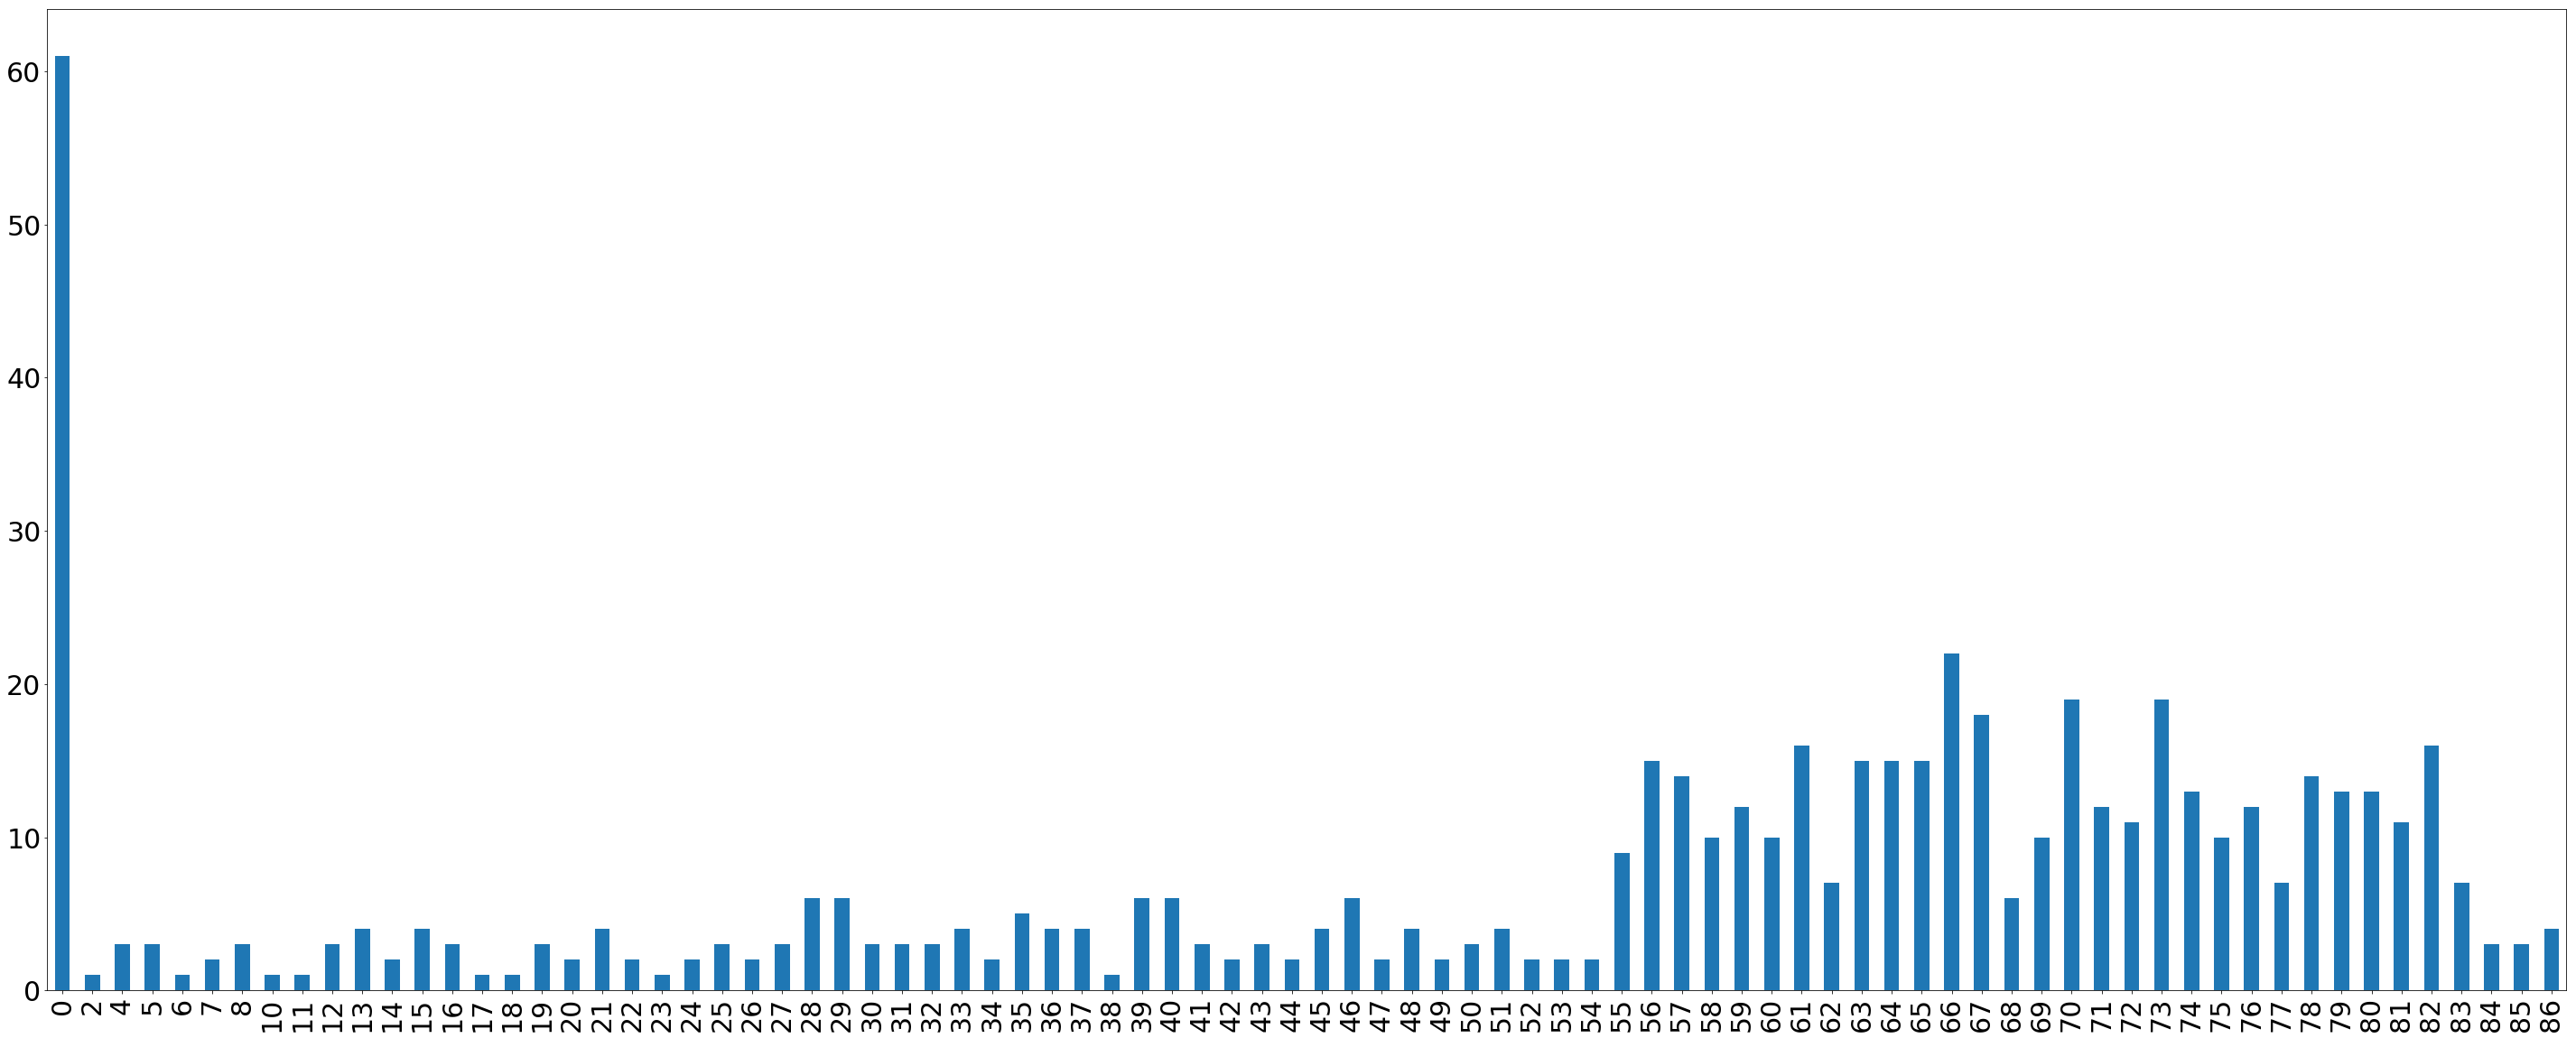

In [515]:
#april onboarded driver's lt

date_rng_begin = datetime.datetime.strptime("04-01-2016", "%m-%d-%Y")
date_rng_end = datetime.datetime.strptime("04-30-2016", "%m-%d-%Y")

apr_driver = driver_ride[driver_ride['driver_onboard_date']>=date_rng_begin][['driver_id','driver_onboard_date','first_ride_dt','last_ride_dt']]
apr_driver = apr_driver[apr_driver['driver_onboard_date']<=date_rng_end]
apr_driver.drop_duplicates(inplace=True)

for index, row in apr_driver.iterrows():
    if(pd.isnull(row['last_ride_dt'])):
        apr_driver.loc[index, 'last_ride_dt'] = apr_driver.loc[index, 'driver_onboard_date']
        
apr_driver['lifetime'] = ((apr_driver['last_ride_dt']-apr_driver['driver_onboard_date'])/np.timedelta64(1, 'D')).astype(int)

apr_driver['lifetime'].value_counts(sort=False).plot(kind='bar')
plt.show()